In [1]:
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import norm
import pymc as pm
print(f"PyMC version - v{pm.__version__}")

PyMC version - v5.22.0


In [2]:
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data = pd.read_csv('./data/housing_price.csv')
data.columns

Index(['Unnamed: 0', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Condition1', 'Condition2', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior2nd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'FireplaceQu', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleConditi

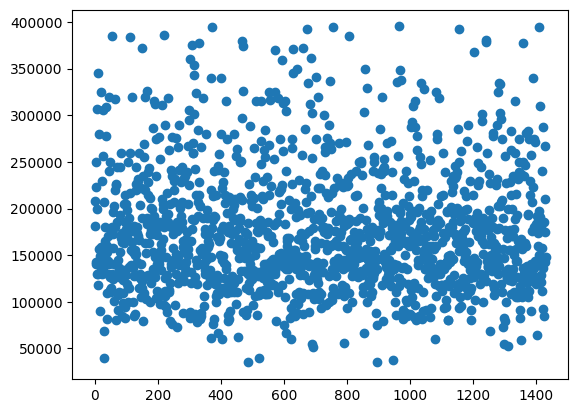

In [4]:
plt.figure()
plt.scatter(range(len(data)),data['SalePrice']);

In [5]:
# to_drop = ['Fence', 'PoolQC','GarageYrBlt', '2ndFlrSF', 'Exterior1st', 'BedroomAbvGr', 'BldgType', 'YearRemodAdd', 'GarageType', 'BsmtFinSF1', 'Neighborhood', 'Fireplaces', 'MasVnrType', 'TotalBsmtSF']
# refer house price data preprocessing notebook for details

df_house = data.copy()
x= df_house.applymap(type).eq(str).any().any()
# nan_cols = x[x>0].index
print(x)

False


/var/folders/5z/y5jrt5n57_q_qvg8yndn3tj00000gn/T/ipykernel_66010/1657672195.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  x= df_house.applymap(type).eq(str).any().any()


In [6]:
(df_house['Utilities'])[468]

2

In [7]:
az.style.use('arviz-darkgrid')
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

def standardize(series,mean,std):
    return (series - mean)/std

## Splitting and scaling the data

0


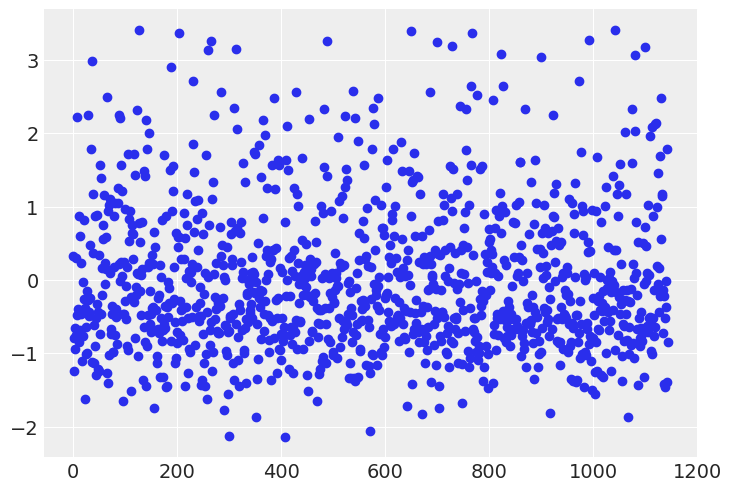

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df_house.drop(columns=['Id','Unnamed: 0','SalePrice']),
    df_house['SalePrice'],
    test_size=0.2,
    random_state=23
    )
mean_train = (X_train.mean(axis=0))
std_train = X_train.std(axis=0)
print(np.sum(std_train==0))

mean_ytrain = y_train.mean(axis=0)
std_ytrain = y_train.std(axis=0)

X_train = (X_train - mean_train)/std_train
X_test = (X_test - mean_train)/std_train
y_train = (y_train - mean_ytrain)/std_ytrain
y_test = (y_test - mean_ytrain)/std_ytrain

plt.figure()
plt.scatter(range(len(X_train)),y_train)

### Hierarchical Model

In [9]:
X_train["MSZoning"].value_counts()

MSZoning
 0.376341    898
-2.107295    176
 1.618160     47
-0.865477     15
-3.349114      9
Name: count, dtype: int64

### Model 1

Building a hierarchical model based on the building-zone of the houses.
Here we try a non centered set of paramters for each zone. 

i.e $$ \alpha = \mu_{\alpha} + \sigma_{\alpha}* z_{\alpha}$$
$$ \beta = \mu_{\beta} + \sigma_{\beta}* z_{\beta}$$
$$ \mu = \sum_{zone} \alpha_{zone} + X_{zone}*\beta_{zone} $$

In [10]:
X_hier = X_train.drop("MSZoning", axis=1)
Zone = X_train["MSZoning"].astype("category").cat.codes
n_zones = Zone.nunique()
col_hier = X_hier.columns

with pm.Model(coords={"zone": np.arange(n_zones), "feature": col_hier}) as hier_model1:
    # Data
    X = pm.Data("X", X_hier.values, dims=["obs", "feature"])
    zone = pm.Data("zone", Zone.values, dims=["obs"])
    Y = pm.Data("Y", y_train.values, dims=["obs"])

    # Hyperpriors
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)

    mu_beta = pm.Normal("mu_beta", mu=0, sigma=1, dims="feature")
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.5, dims="feature")

    # Non-centered group-level parameters
    z_alpha = pm.Normal("z_alpha", mu=0, sigma=1, dims="zone")
    alpha = pm.Deterministic("alpha", mu_alpha + sigma_alpha * z_alpha)

    z_beta = pm.Normal("z_beta", mu=0, sigma=1, dims=("zone", "feature"))
    beta = pm.Deterministic("beta", mu_beta + sigma_beta* z_beta)

    # Expected value per observation
    mu = pm.Deterministic("mu",alpha[zone] + (X * beta[zone]).sum(axis=1))

    sigma = pm.HalfNormal("sigma", sigma=2)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)

    idata = pm.sample(return_inference_data=True,idata_kwargs={'log_likelihood':True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, z_alpha, z_beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1458 seconds.
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


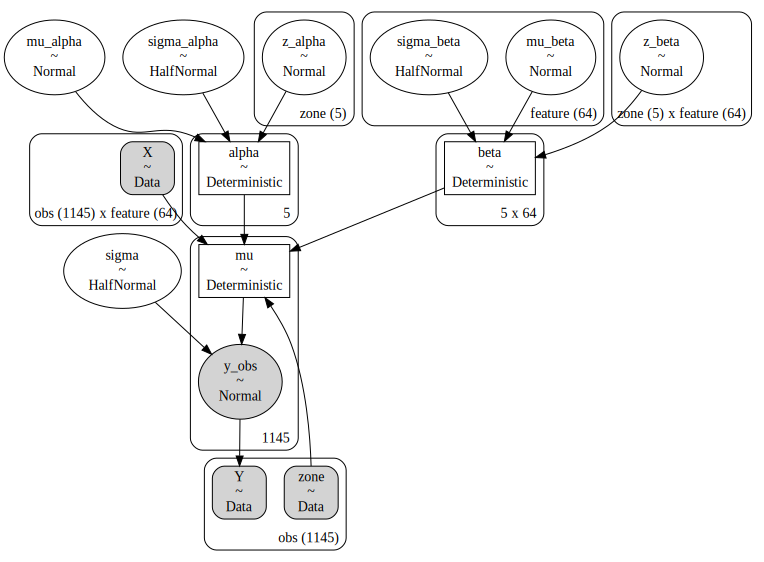

In [11]:
pm.model_to_graphviz(hier_model1)

In [16]:
X_test_hier = X_test.drop("MSZoning", axis=1)
Zone_test = X_test["MSZoning"].astype("category").cat.codes
with hier_model1:
    pm.set_data({"X": X_test_hier.values, "zone": Zone_test.values})
    posterior_preds = pm.sample_posterior_predictive(idata, var_names=["mu"])
    
mean_preds = posterior_preds.posterior_predictive["mu"].mean(["chain","draw"])
print("MSE : ",mean_squared_error(y_test,mean_preds))
print("R2 score : ",r2_score(y_test,mean_preds))


Sampling: [z_alpha, z_beta]


Output()

MSE :  0.20870682286895437
R2 score :  0.8187337079303482


Model had considerable divergences. Let try a simpler model and try to build on it.

### Model 2 

Instead of aa non centered parameter form, let try with a centered one i.e $z_{\beta/\alpha}=1$

In [17]:
X_hier = X_train.drop(columns=["MSZoning"])
zones = X_train["MSZoning"].astype("category").cat.codes
n_zones = zones.nunique()
col_hier = X_hier.columns

with pm.Model(coords={"zone":np.arange(n_zones),"features":col_hier}) as hier_model2:
    X = pm.Data("X",X_hier,dims=["obs","features"])
    mzone = pm.Data("Zone",zones,dims=["obs"])
    Y = pm.Data("Y",y_train,dims=["obs"])

    sigma_alpha = pm.HalfNormal("sigma_alpha",sigma=1)
    mu_alpha = pm.Normal("mu_alpha",mu=0,sigma=1)
    alpha = pm.Normal("alpha",mu = mu_alpha, sigma=sigma_alpha , shape = n_zones)

    lambda_ = pm.HalfNormal("lambda",sigma=2)
    mu_beta = pm.Normal("mu_beta",mu=0,sigma=1)
    beta = pm.Laplace("betas",mu=mu_beta,b=lambda_,dims=["zone","features"])

    mu = pm.Deterministic("mu",alpha[mzone]+pm.math.sum(X * beta[mzone], axis=1))
    sigma= pm.HalfNormal("sigma",sigma=2)
    y_obs = pm.StudentT("y_obs",mu=mu,sigma=sigma,nu=10,observed=Y)
    idata_hier2 = pm.sample(return_inference_data=True,idata_kwargs={'log_likelihood':True})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_alpha, mu_alpha, alpha, lambda, mu_beta, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 622 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Lets look at the summary of model parameters

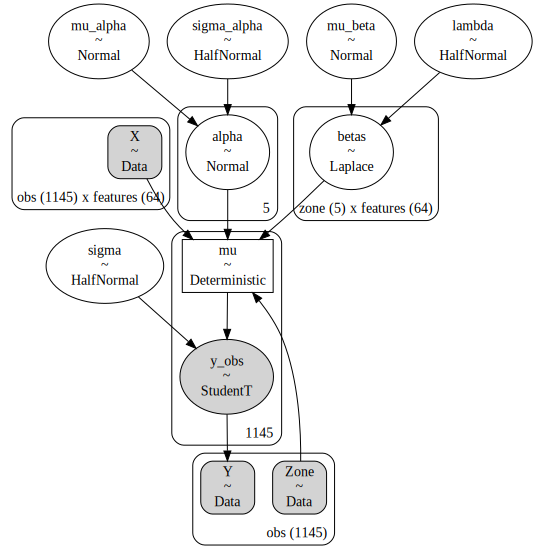

In [18]:
pm.model_to_graphviz(hier_model2)

In [ ]:
az.summary(idata_hier,var_names = ["betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, MSSubClass]",0.027,0.044,-0.056,0.119,0.001,0.001,5031.0,2347.0,1.0
"betas[0, LotFrontage]",0.028,0.046,-0.057,0.129,0.001,0.001,5296.0,2303.0,1.0
"betas[0, LotArea]",0.026,0.050,-0.075,0.122,0.001,0.002,3950.0,1817.0,1.0
"betas[0, Street]",0.029,0.023,-0.015,0.075,0.000,0.000,3096.0,2740.0,1.0
"betas[0, Alley]",0.006,0.038,-0.071,0.074,0.001,0.001,3843.0,2222.0,1.0
...,...,...,...,...,...,...,...,...,...
"betas[4, MiscVal]",0.024,0.052,-0.076,0.122,0.001,0.002,3649.0,1952.0,1.0
"betas[4, MoSold]",0.017,0.030,-0.046,0.074,0.000,0.001,4072.0,2684.0,1.0
"betas[4, YrSold]",0.034,0.028,-0.016,0.092,0.000,0.001,4452.0,2317.0,1.0
"betas[4, SaleType]",0.020,0.025,-0.031,0.067,0.000,0.001,3984.0,2512.0,1.0


/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (5900) in plot_autocorr, generating only 40 plots
  warnings.warn(


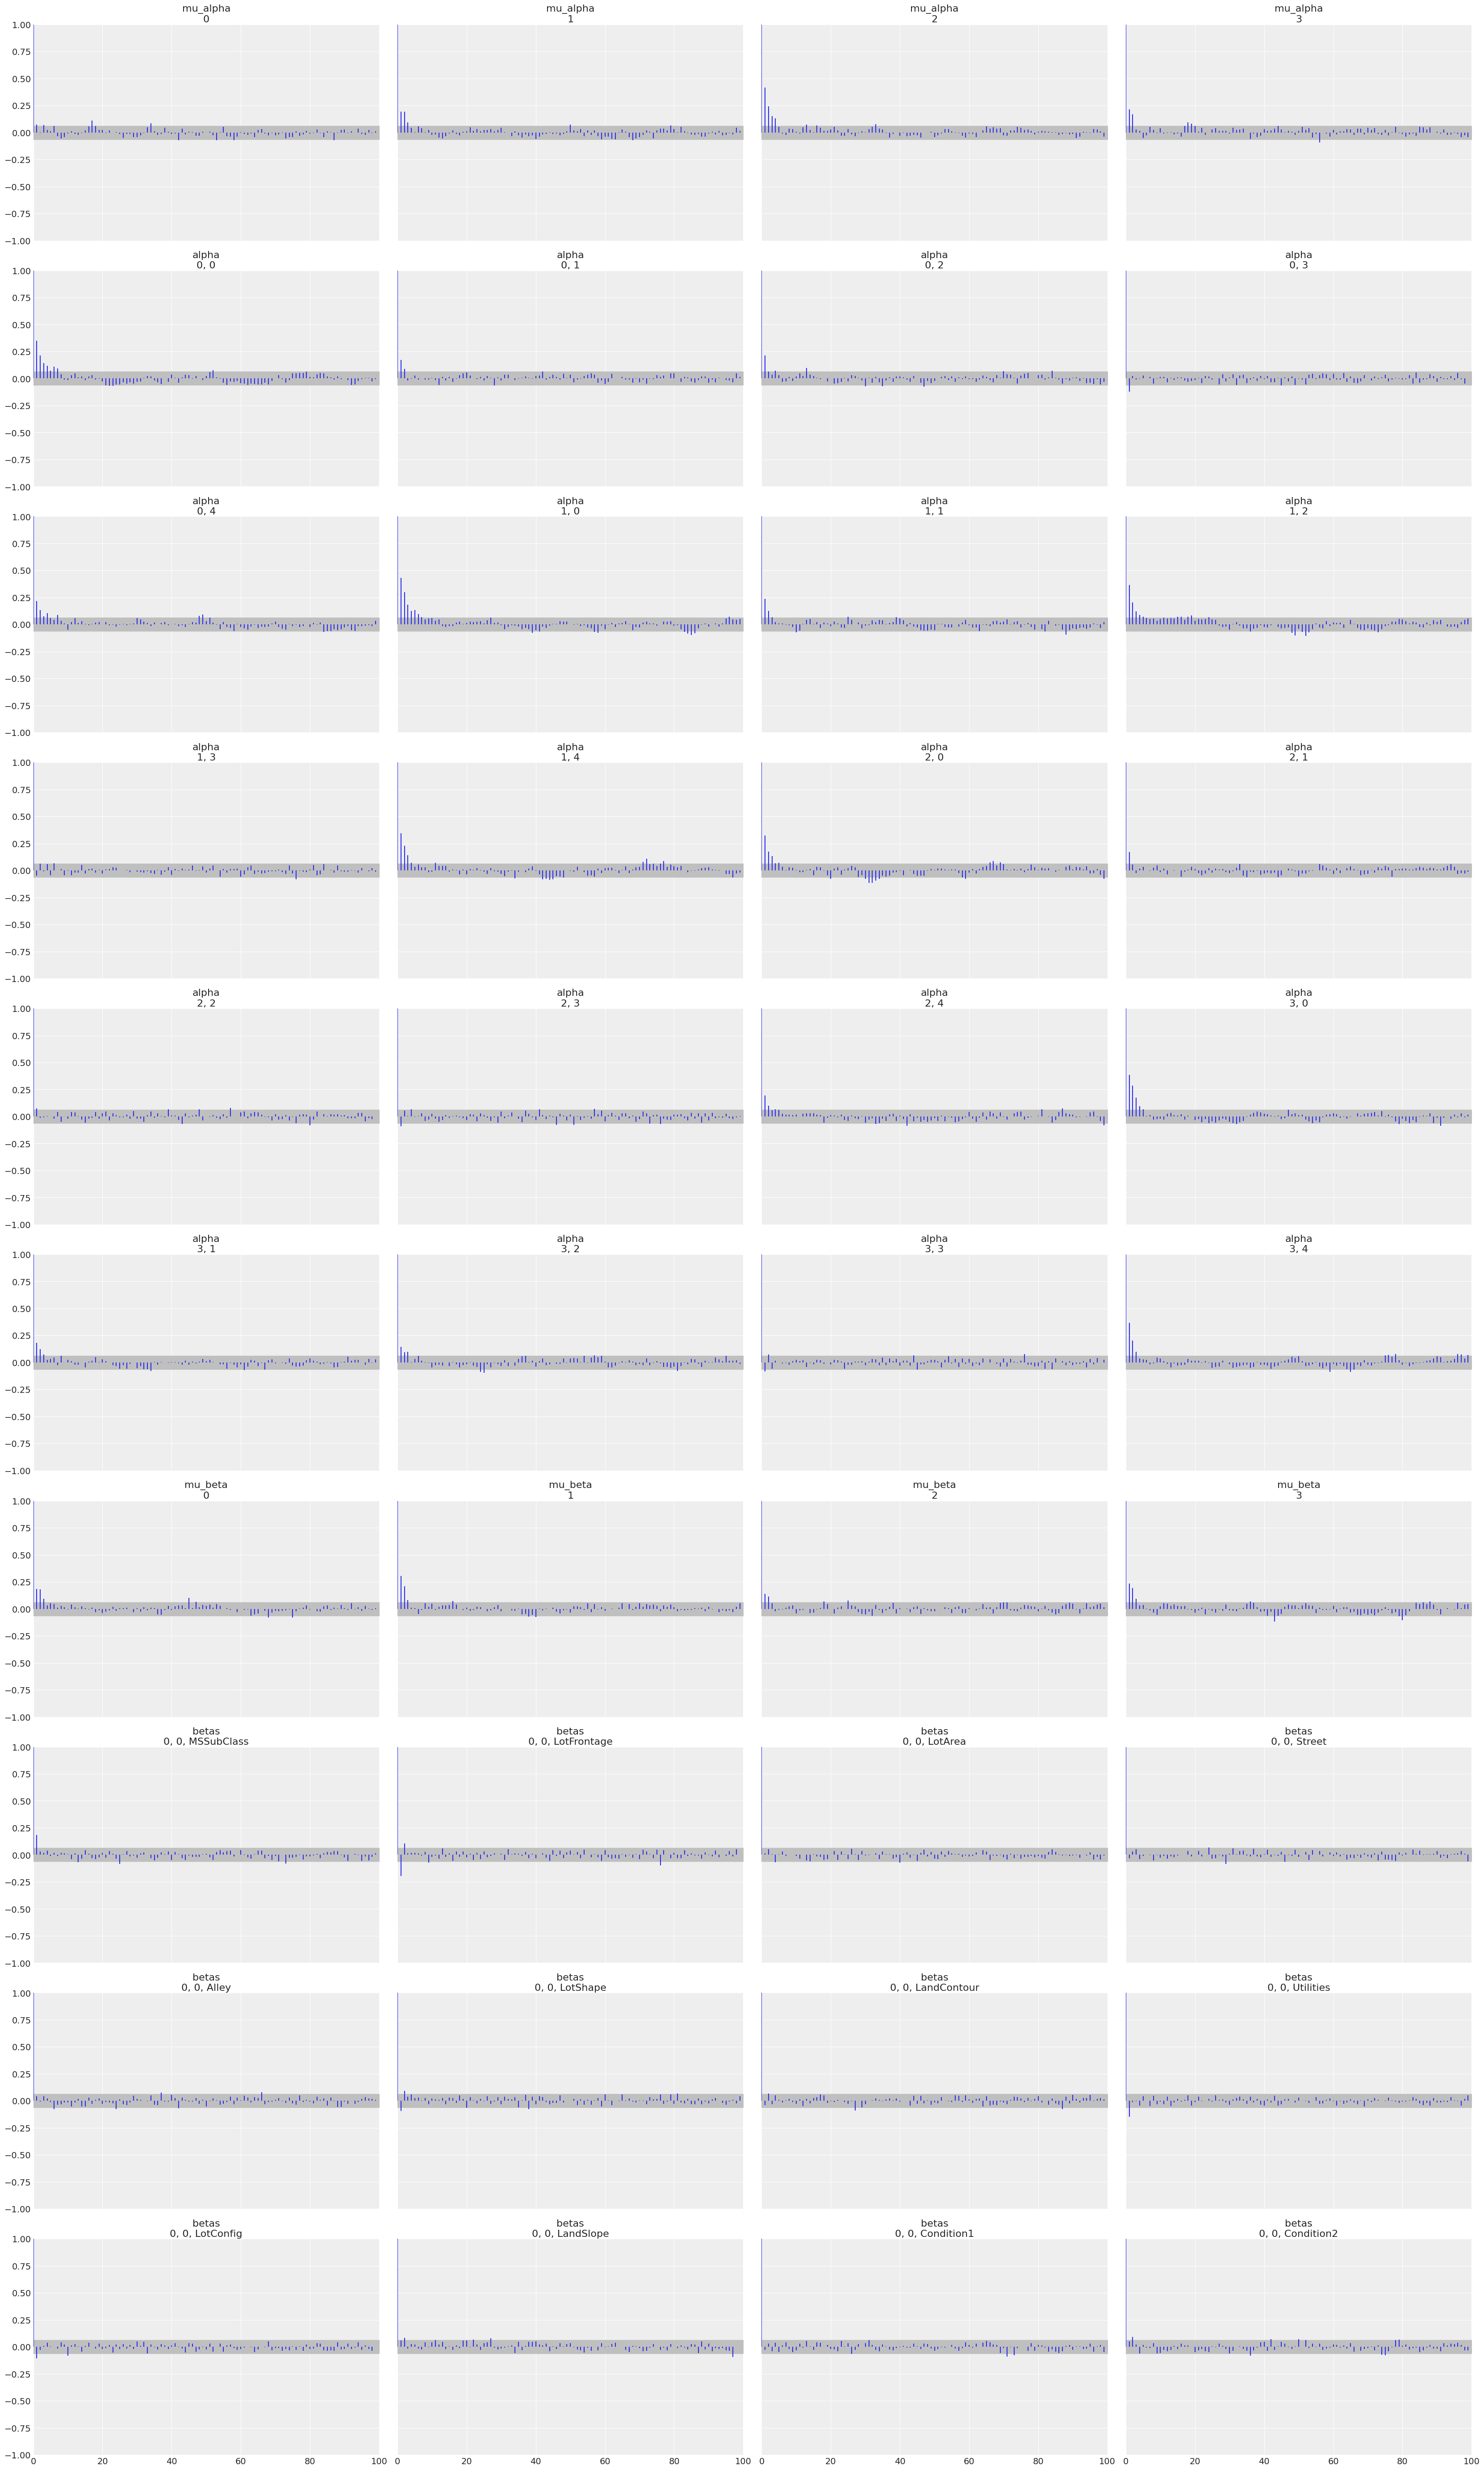

In [ ]:
az.plot_autocorr(idata_hier);

The above shows the autocorr between steps while sampling. The plot shows as we move right the whatever autocorrelation was present dies off indicating a robust sampling

Lets look at the posterior predictions of y_obs

Sampling: [y_obs]


Output()

<AxesSubplot: xlabel='y_obs'>

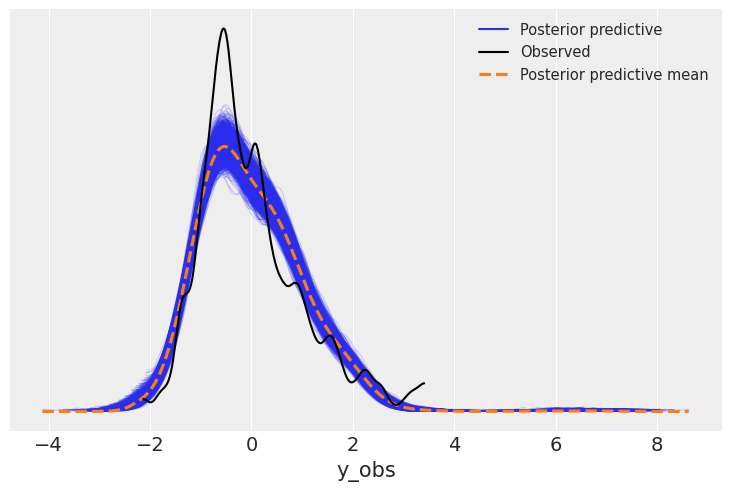

In [19]:
with hier_model2:
    ppc = pm.sample_posterior_predictive(idata_hier2)
    idata_hier2.extend(ppc)

az.plot_ppc(idata_hier2)

We are able to decently capture the trend but not able match the peak at the center.
### Model 3
Lets assign separate means and sigma to each feature. Here mu_beta and sigma_beta of agiven feature is shared across zone. This is make sure for zones with less datapoint it doesnt overfit.

In [20]:
coords = {"zones":np.arange(n_zones),"features":col_hier}
with pm.Model(coords = coords) as hier_model3:
    X = pm.Data("X",X_hier,dims=["obs","features"])
    mzone = pm.Data('Zones',zones,dims=["obs"])
    Y = pm.Data("Y",y_train,dims=["obs"])

    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)
    mu_alpha = pm.Normal("mu_alpha",mu=0,sigma=1)
    alpha = pm.Normal("alpha",mu=mu_alpha,sigma=sigma_alpha,dims=["zones"])

    mu_beta = pm.Normal("mu_beta",mu=0,sigma=1,dims=["features"])
    lambda_= pm.HalfNormal("lambda",sigma=2,dims=["features"])
    beta = pm.Laplace("betas",mu=mu_beta,b=lambda_,dims=["zones","features"])

    mu = pm.Deterministic("mu",alpha[mzone]+pm.math.sum(X*beta[mzone],axis=1))
    sigma= pm.HalfNormal("sigma",sigma=1)
    y_obs = pm.StudentT("y_obs",mu=mu,sigma=sigma,nu=10,observed=Y)
    idata_hier3 = pm.sample(return_inference_data=True,idata_kwargs={'log_likelihood':True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_alpha, mu_alpha, alpha, mu_beta, lambda, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4227 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


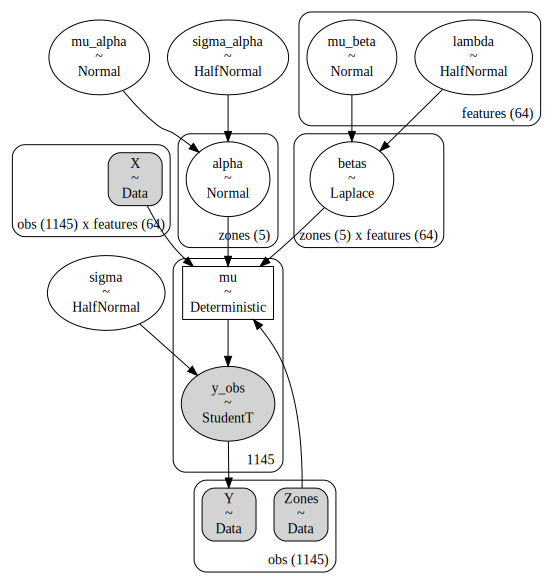

In [ ]:
pm.model_to_graphviz(hier_model3)

/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (64) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'lambda\nMSSubClass'}>,
        <AxesSubplot: title={'center': 'lambda\nLotFrontage'}>,
        <AxesSubplot: title={'center': 'lambda\nLotArea'}>,
        <AxesSubplot: title={'center': 'lambda\nStreet'}>],
       [<AxesSubplot: title={'center': 'lambda\nAlley'}>,
        <AxesSubplot: title={'center': 'lambda\nLotShape'}>,
        <AxesSubplot: title={'center': 'lambda\nLandContour'}>,
        <AxesSubplot: title={'center': 'lambda\nUtilities'}>],
       [<AxesSubplot: title={'center': 'lambda\nLotConfig'}>,
        <AxesSubplot: title={'center': 'lambda\nLandSlope'}>,
        <AxesSubplot: title={'center': 'lambda\nCondition1'}>,
        <AxesSubplot: title={'center': 'lambda\nCondition2'}>],
       [<AxesSubplot: title={'center': 'lambda\nHouseStyle'}>,
        <AxesSubplot: title={'center': 'lambda\nOverallQual'}>,
        <AxesSubplot: title={'center': 'lambda\nOverallCond'}>,
        <AxesSubplot: title={'center': 'lambda\nYearBuilt'}>],
  

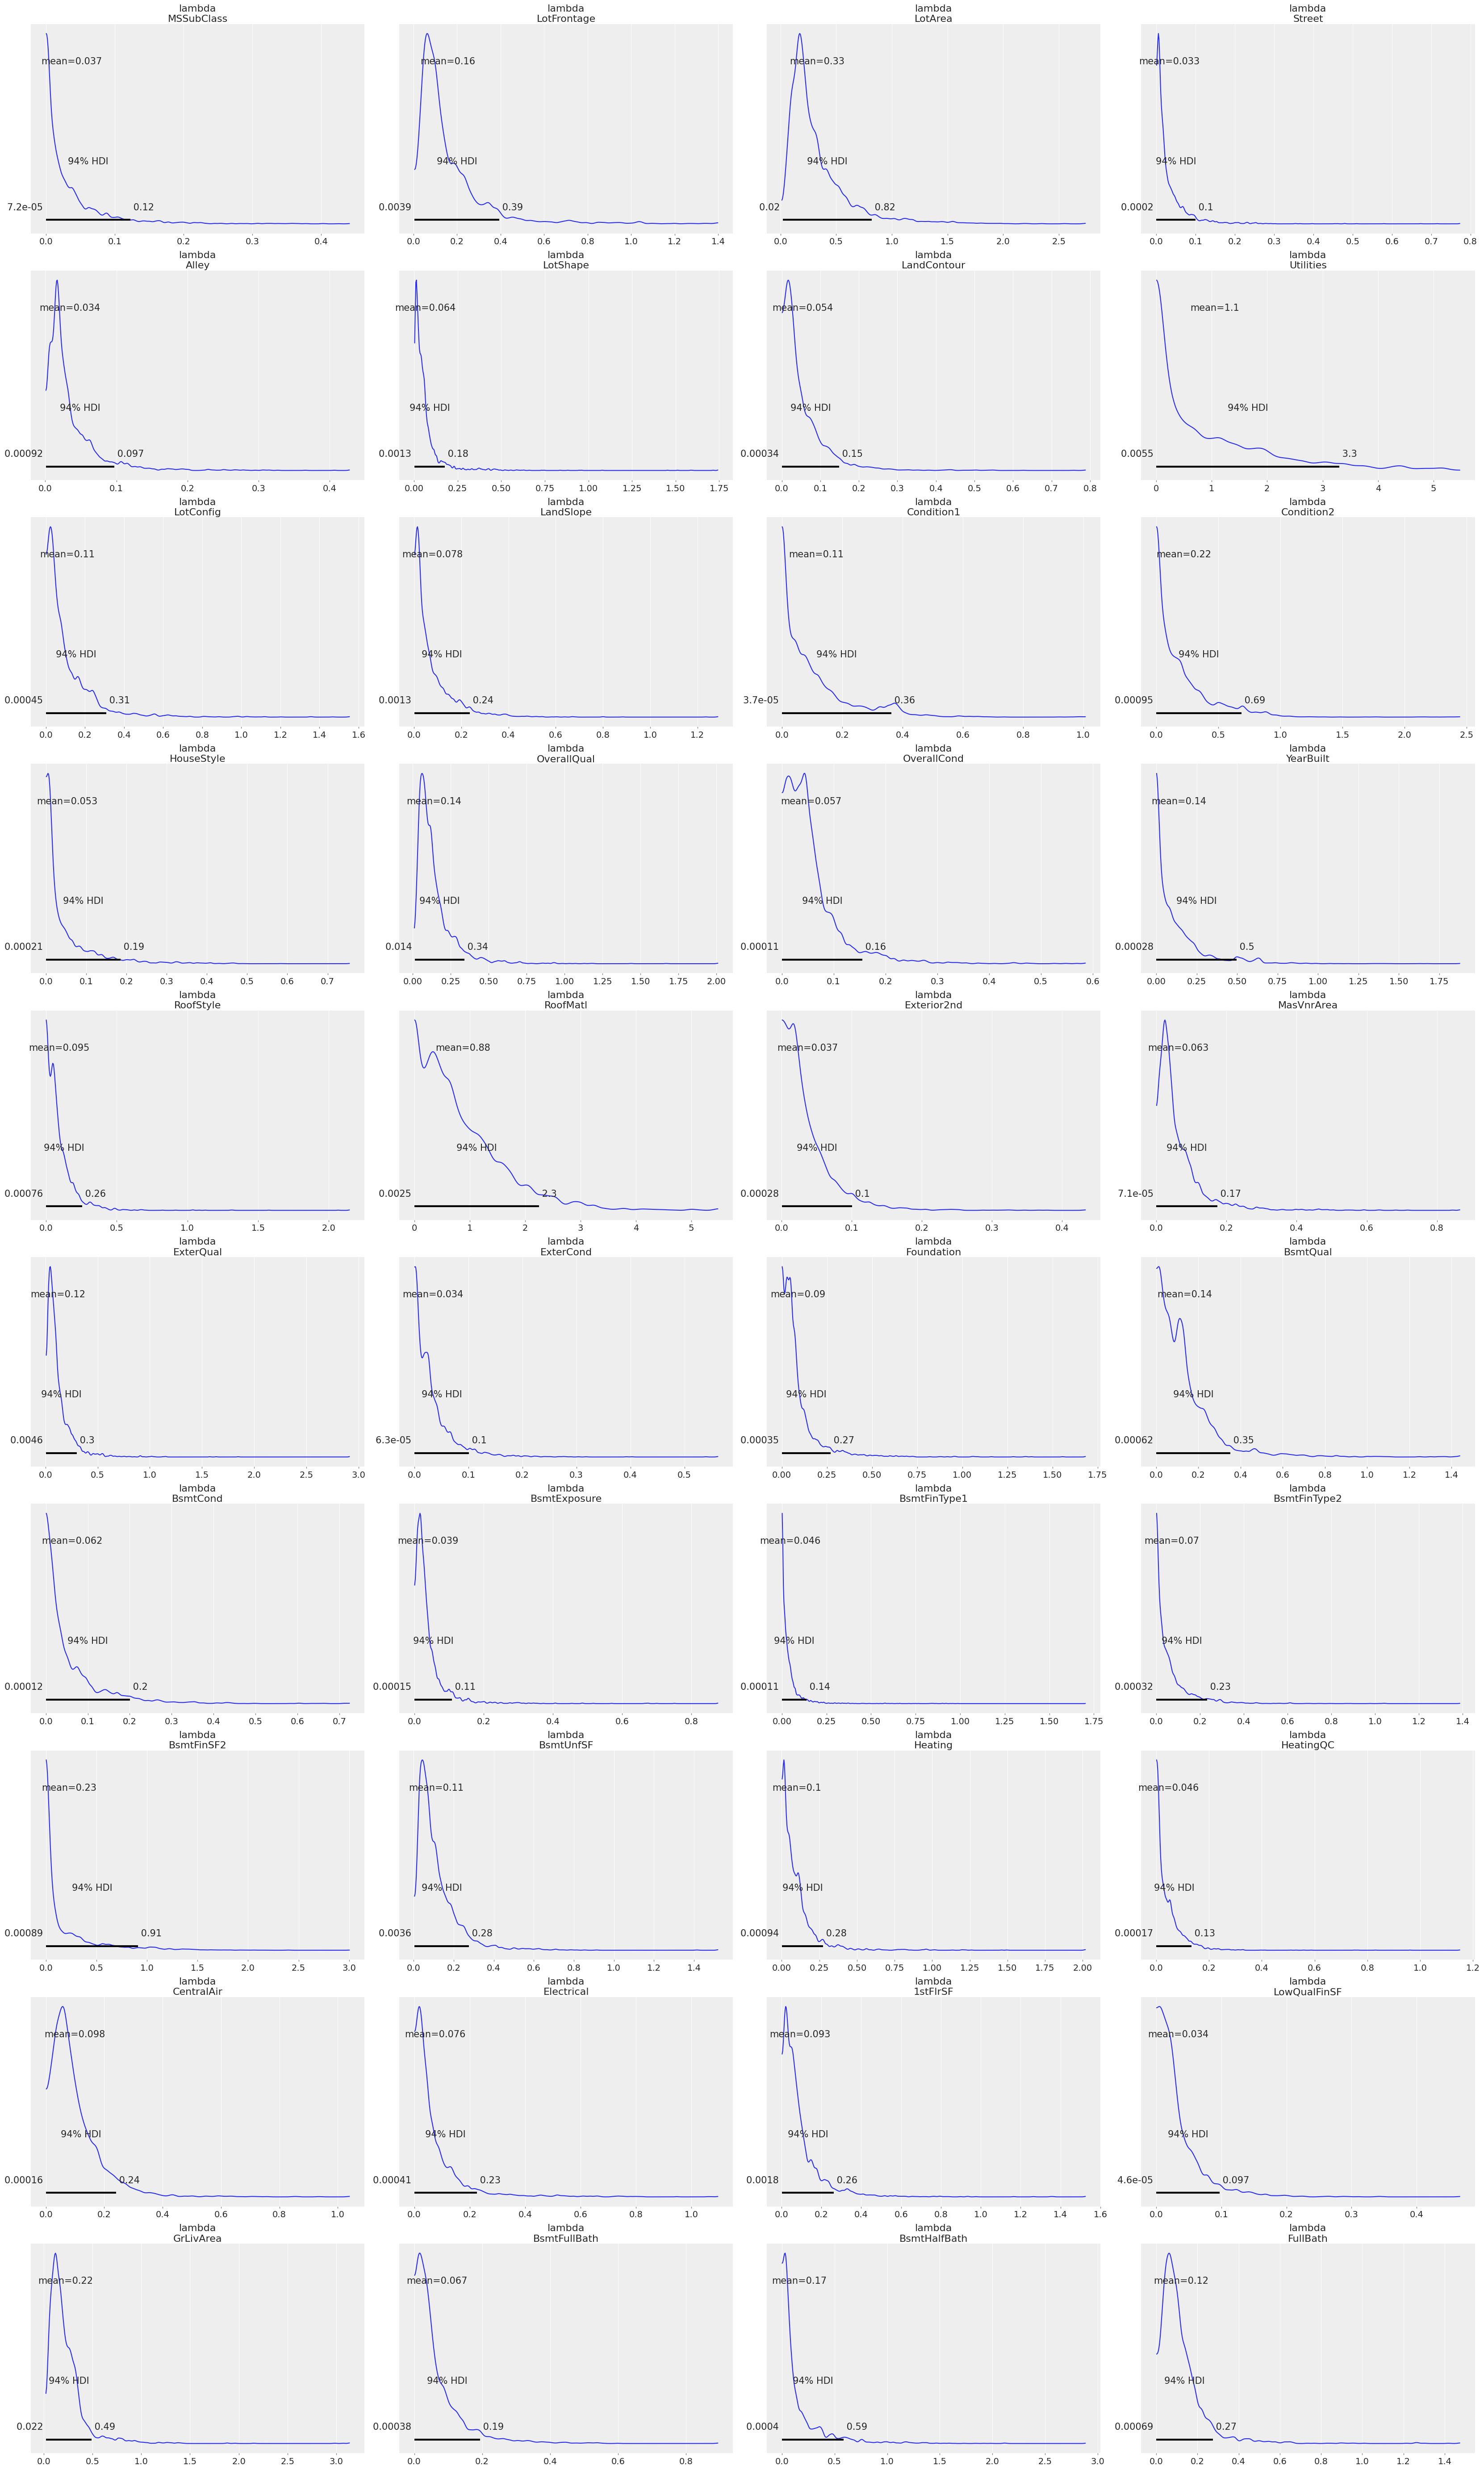

In [ ]:
az.plot_posterior(idata_hier3,var_names=['lambda'])

Sampling: [y_obs]


Output()

<AxesSubplot: xlabel='y_obs'>

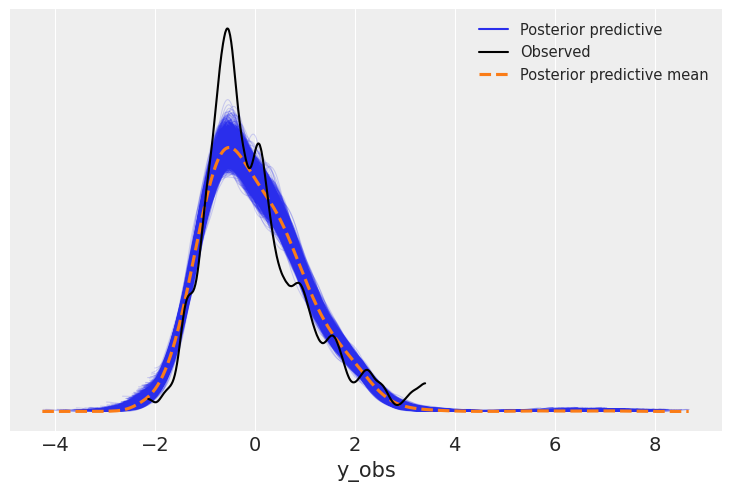

In [21]:
with hier_model3:
    ppc = pm.sample_posterior_predictive(idata_hier3)
    idata_hier3.extend(ppc)

az.plot_ppc(idata_hier3)

The sampler is struggling because of the geometry of the parameter space because of tighter constrains on parameters. Lets try a relaxed model.

### Model 4

Exponential prior for sigma_beta thereby allowing larger feature values and a normal distribution for beta. THis eases the work of sampler.

In [27]:
# Using normal distribution for beta and exponential for beta_sigma
with pm.Model(coords=coords) as hier_model4:
    X = pm.Data("X",X_hier,dims=["obs","feature"])
    mzone = pm.Data("Zones",zones,dims=["obs"])
    Y = pm.Data("Y",y_train,dims=["obs"])

    mu_alpha = pm.Normal("mu_alpha",mu=0,sigma=1)
    sigma_alpha = pm.HalfNormal("sigma_alpha",sigma=1)
    alpha = pm.Normal("alpha",mu=mu_alpha,sigma=sigma_alpha,dims=["zones"])

    mu_beta = pm.Normal("mu_betas",mu=0,sigma=1,dims=["features"])
    sigma_beta = pm.Exponential("sigma_beta",1,dims=["features"])
    beta = pm.Normal("betas",mu=mu_beta,sigma=sigma_beta,dims=["zones","features"])

    mu = pm.Deterministic("mu",alpha[mzone]+pm.math.sum(X*beta[mzone],axis=1))
    sigma= pm.HalfNormal("sigma",sigma=1)
    y_obs = pm.StudentT("Y_obs",mu=mu,sigma=sigma,nu=10,observed=Y)
    idata_hier4 = pm.sample(return_inference_data=True, idata_kwargs={"log_likelihood":True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, alpha, mu_betas, sigma_beta, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2380 seconds.
There were 1549 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


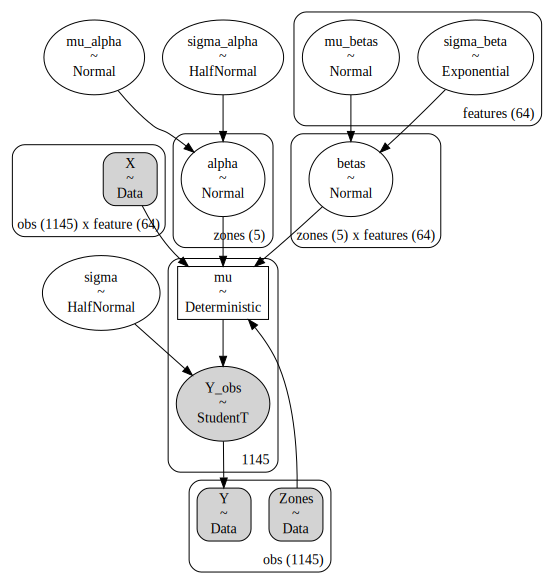

In [68]:
pm.model_to_graphviz(hier_model4)

<AxesSubplot: >

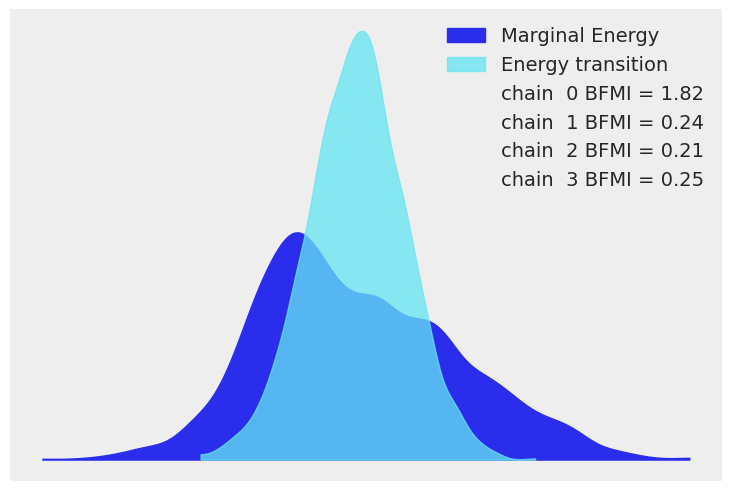

In [28]:
az.plot_energy(idata_hier4)

<AxesSubplot: xlabel='sigma_beta\nOverallQual', ylabel='betas\n1, OverallQual'>

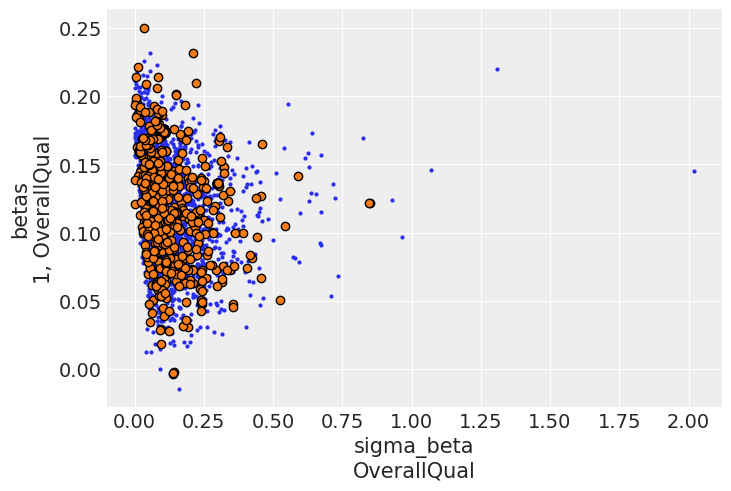

In [29]:
az.plot_pair(idata_hier4,var_names=["sigma_beta","betas"],coords={"features":["OverallQual"],"zones":[1]},divergences=True)

Exponential prior didnt help us here as a narrowed the neck in the posterior. THis is a classic funnel problem. NUTS cant explore this space. In order to break the coupling between beta and sigma_beta we can use a non-centered formulation.

### Model 5

Here we bring back z_beta again

In [22]:
with pm.Model(coords=coords) as hier_model5:
    X= pm.Data("X",X_hier,dims=["obs","features"])
    mzone = pm.Data("Zones",zones,dims=["obs"])
    Y = pm.Data("Y",y_train,dims=["obs"])

    mu_alpha = pm.Normal("mu_alpha",mu=0,sigma=1)
    sigma_alpha = pm.HalfNormal("sigma_alpha",sigma=1)
    alpha = pm.Normal("alpha",mu=mu_alpha,sigma=sigma_alpha,dims=["zones"])

    mu_beta = pm.Normal("mu_beta",mu=0,sigma=1,dims=["features"])
    sigma_beta = pm.HalfNormal("sigma_beta",sigma=1,dims=["features"])
    z_beta = pm.Normal("z_beta",mu=0,sigma=1,dims=["zones","features"])
    beta = pm.Normal("beta",mu=mu_beta + sigma_beta*z_beta,dims=["zones","features"])

    mu= pm.Deterministic('mu',alpha[mzone] + pm.math.sum(X*beta[mzone],axis=1))
    sigma= pm.HalfNormal("sigma",sigma=1)
    y_obs = pm.StudentT("y_obs",mu=mu,sigma=sigma,nu=10,observed=Y)
    idata_hier5 = pm.sample(return_inference_data=True, idata_kwargs=({"log_likelihood":True}))



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, alpha, mu_beta, sigma_beta, z_beta, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1270 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


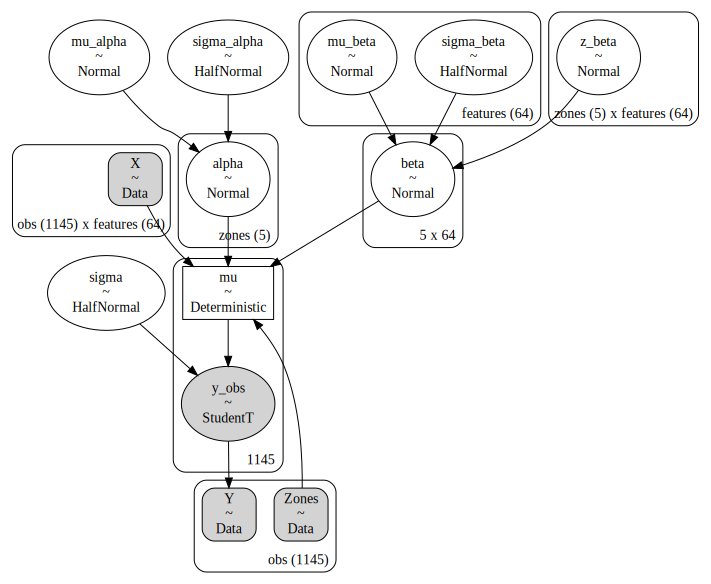

In [62]:
pm.model_to_graphviz(hier_model5)

<AxesSubplot: >

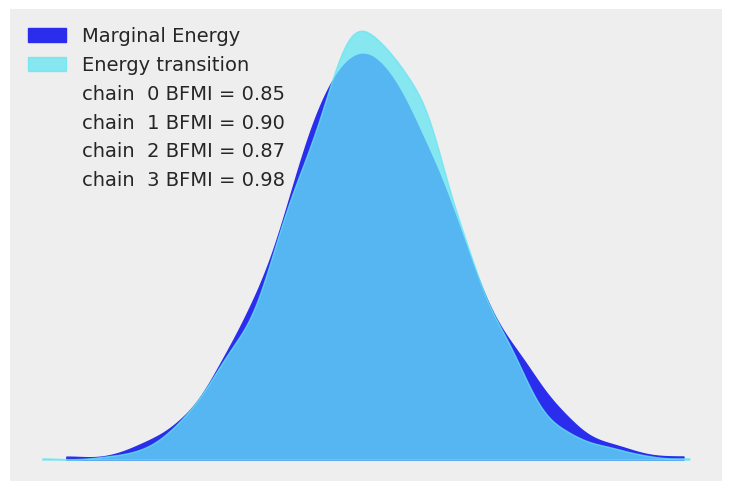

In [23]:
az.plot_energy(idata_hier5)

<AxesSubplot: xlabel='sigma_beta\nOverallQual', ylabel='beta\n1, OverallQual'>

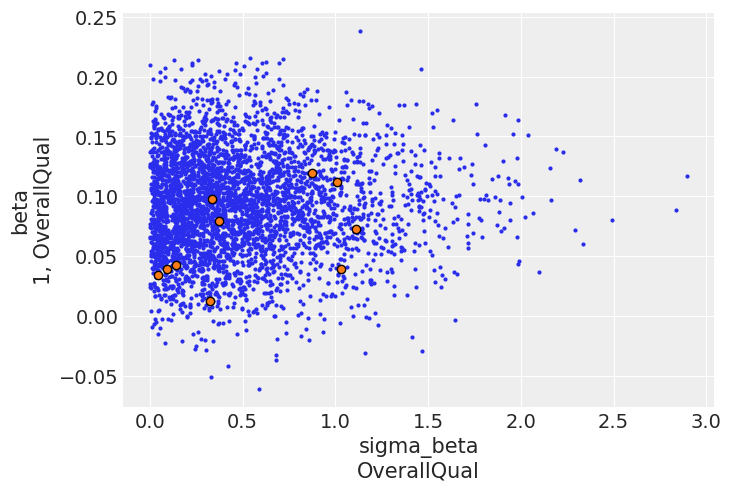

In [88]:
az.plot_pair(idata_hier5,var_names = ["sigma_beta","beta"],coords={"features":["OverallQual"],"zones":[1]},divergences=True)

Sampling: [y_obs]


Output()

<AxesSubplot: xlabel='y_obs'>

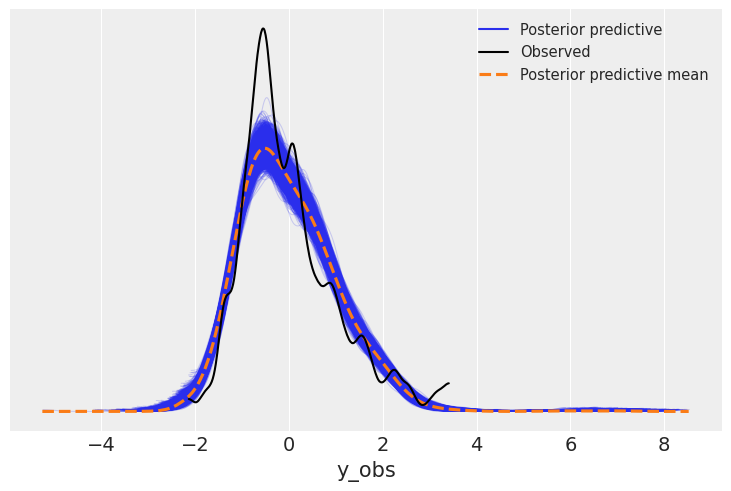

In [24]:
with hier_model5:
    ppc = pm.sample_posterior_predictive(idata_hier5)
    idata_hier5.extend(ppc)

az.plot_ppc(idata_hier5)

In [85]:
Zone_test.shape

(287,)

In [25]:
with hier_model5:
    pm.set_data({"X":X_test_hier.values,"Zones":Zone_test.values})
    posterior_pred = pm.sample_posterior_predictive(idata_hier5,var_names=["mu"])

y_pred = posterior_pred.posterior_predictive["mu"].mean(["chain","draw"])
print("MSE : ",mean_squared_error(y_test,y_pred))
print("R2_score : ",r2_score(y_test,y_pred))

Sampling: []


Output()

MSE :  0.145090903834836
R2_score :  0.87398547977663


Lets analyze the parameters

In [ ]:
# # mu_beta_samples = idata_hier3.posterior["mu_beta"].stack(sample=("chain","draw")).values
# # beta_samples = idata_hier3.posterior["betas"].stack(sample=("chain","draw")).values

# n_features = len(col_hier)

# fig, axs = plt.subplots(n_features, 1, figsize=(8, 3 * n_features), sharex=True)
# for i, feature in enumerate(col_hier):
#     ax = axs[i] if n_features > 1 else axs
#     ax.set_title(f"Zone-specific β vs μ_β for feature '{feature}'")

#     # Plot mu_beta for this feature
#     mu_beta_vals = idata_hier3.posterior["mu_beta"].sel(features=feature).values.flatten()
#     ax.hist(mu_beta_vals, bins=50, alpha=0.5, label="μ_β", color='orange', density=True)

#     # Plot beta for each zone for this feature
#     for z in zones:
#         beta_vals = idata_hier3.posterior["betas"].sel(features=feature, zones=z).values.flatten()
#         ax.hist(beta_vals, bins=50, alpha=0.2, label=f"β (zone {z})", density=True)

#     ax.legend()

# plt.tight_layout()
# plt.show()

Lets compare the two models

In [30]:
az.compare({"feature_mu":idata_hier2,"smallerr beta":idata_hier3},ic='loo')

/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
smallerr beta,0,-356.723127,140.616235,0.000000,0.446779,38.670654,0.00000,True,log
feature_mu,1,-364.552183,132.851779,7.829057,0.553221,40.380393,10.83719,True,log


In [29]:
az.loo(idata_hier3, pointwise=True)

/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 1145 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -356.72    38.67
p_loo      140.62        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1123   98.1%
   (0.70, 1]   (bad)        19    1.7%
   (1, Inf)   (very bad)    3    0.3%

In [17]:
X_train["MSSubClass"].value_counts()

MSSubClass
-0.882298    412
 0.043458    226
-0.187981    111
 1.432092     76
-0.650859     56
 2.357848     53
 0.506336     49
 0.274897     47
 0.737775     42
 3.052165     25
 0.622055     15
 0.390616     12
-0.303700      9
 2.820726      8
-0.419420      4
Name: count, dtype: int64

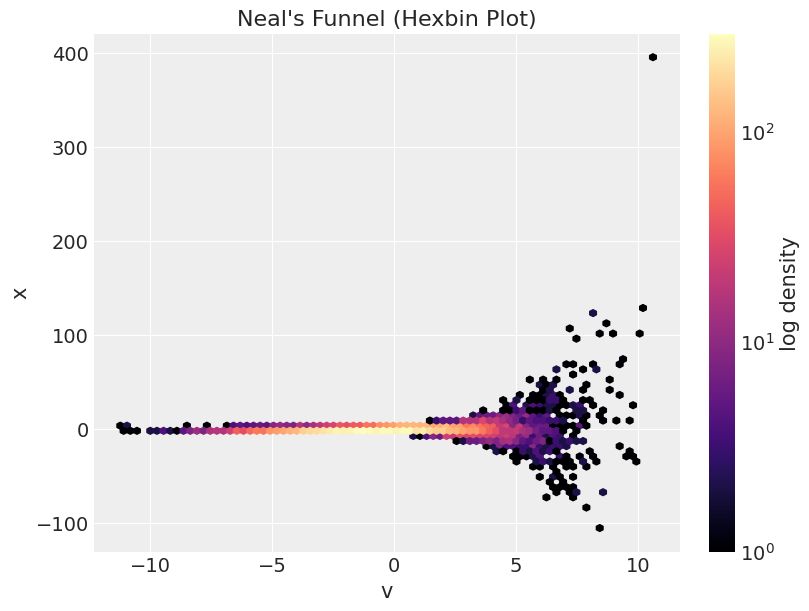

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Funnel simulation
n = 10_000
v = np.random.normal(0, 3, size=n)
x = np.random.normal(0, np.exp(v / 2))

plt.figure(figsize=(8, 6))
plt.hexbin(v, x, gridsize=80, cmap='magma', bins='log')
plt.xlabel("v")
plt.ylabel("x")
plt.title("Neal's Funnel (Hexbin Plot)")
plt.colorbar(label="log density")
plt.grid(True)
plt.show()


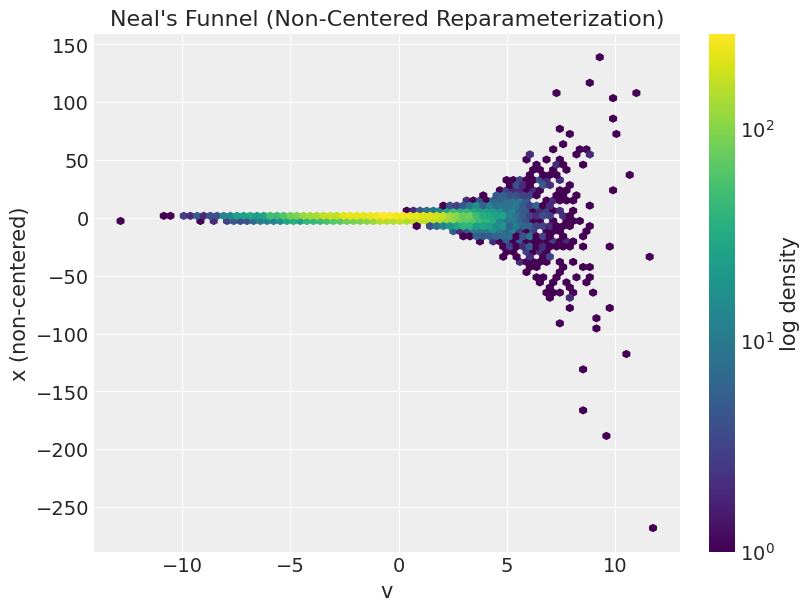

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Non-centered funnel simulation
n = 10_000
v_nc = np.random.normal(0, 3, size=n)
z = np.random.normal(0, 1, size=n)
x_nc = z * np.exp(v_nc / 2)

# Plot
plt.figure(figsize=(8, 6))
plt.hexbin(v_nc, x_nc, gridsize=80, cmap="viridis", bins='log')
plt.xlabel("v")
plt.ylabel("x (non-centered)")
plt.title("Neal's Funnel (Non-Centered Reparameterization)")
plt.colorbar(label="log density")
plt.grid(True)
plt.show()
